In [1]:
import pandas as pd
import numpy as np
import datetime
import os
import pickle
import time

import warnings
warnings.filterwarnings('ignore')

%pylab inline
import matplotlib.pylab as plt
import seaborn as sns
plt.style.use('ggplot')
plt.style.use('seaborn-poster')
sns.set_palette('Set1', 10, desat=0.75)

from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split, GroupKFold, KFold
from scipy.sparse import csr_matrix, coo_matrix,hstack, vstack
DATA_PATH = 'data/'

Populating the interactive namespace from numpy and matplotlib


In [2]:
data = pd.concat([pd.read_csv(os.path.join(DATA_PATH, 'train_nonNLP_features.csv')),
                  pd.read_csv(os.path.join(DATA_PATH, 'train_NLP_features.csv')),
                  pd.read_csv(os.path.join(DATA_PATH, 'train_pos_diff_matrix.csv')),
                  pd.read_csv(os.path.join(DATA_PATH, 'train_PN.csv')),
                  pd.read_csv(os.path.join(DATA_PATH, 'train_lgb_tfidf_oof.csv')),
                  pd.read_csv(os.path.join(DATA_PATH, 'train_nnet_tfidf_oof.csv')),
                  pd.read_csv(os.path.join(DATA_PATH, 'train_fm_oof.csv')),
                 ], axis=1)#[:100000]

target = pd.read_csv(os.path.join(DATA_PATH, 'target.csv')).target#[:100000]
data.head(5)

,q1_total_counts,q2_total_counts,sum_count,q1_counts_in_q1,q1_counts_in_q2,q2_counts_in_q1,q2_counts_in_q2,q1_in_q2_share,q2_in_q1_share,jaccard_dist_nbr_1,...,loc_city_match_num,loc_city_match_relative,loc_city_mismatch_num,loc_city_mismatch_relative,loc_q1_city_num,loc_q2_city_num,lgb_tfidf_oof,lgb_tfidfpca_oof,nnet_tfidf_oof,FM_oof
0,1,2,3.0,1,0,1.0,1,0.000000,1.0,0.0,...,0,-1.0,0,-1.0,0,0,0.288244,0.306657,2.187292e-01,0.311618
1,8,3,11.0,7,1,2.0,1,0.142857,2.0,0.0,...,1,0.5,0,0.0,1,1,0.293808,0.435092,1.393378e-01,0.302342
2,2,1,3.0,1,1,0.0,1,1.000000,0.0,0.0,...,0,-1.0,0,-1.0,0,0,0.368330,0.593106,4.971907e-01,0.319215
3,1,1,2.0,1,0,0.0,1,0.000000,0.0,0.0,...,0,-1.0,0,-1.0,0,0,0.000616,0.000598,1.181926e-08,0.299354
4,3,1,4.0,3,0,0.0,1,0.000000,0.0,0.0,...,0,0.0,1,1.0,1,0,0.056711,0.375343,3.728851e-02,0.315754


# Remove features uncorrelated with target and correlated with other features

In [3]:
%%time
features = [col for col in data.columns if data[col].dtypes in ['int', 'float'] and col!='target']

data['target'] = target
features_to_drop = dict()
feature_target_corrs = dict()

# Fill the feature_target_corrs dict dictionary of correlations with target for each feature.
# If feature-target correlation is closer to zero than 0.001, then the feature is removed.
for feature in features:
    correlation = data[['target', feature]].corr(method='spearman').iloc[0][1]
    feature_target_corrs[feature] = correlation
    if abs(correlation)<1e-3:
        features_to_drop[feature] = correlation

CPU times: user 33.8 s, sys: 4.57 s, total: 38.3 s
Wall time: 38.5 s


In [4]:
%%time
def get_correlated_features(data, features, features_to_drop, feature_target_corrs, 
                            target_corr_difference_threshold, 
                            features_corr_threshold):
    """
    imput:
        data - pandas DataFrame with features and target
        features - list of feature names to be tested. All of them must be contained in data
        features_to_drop - dictionary with bad features
        feature_target_corrs - dictionary, where feature names are the keys and their 
        correlations with target are values
        target_corr_difference_threshold - float. If difference between two features correlation with 
        target is smaller than this value, then feature-feature correlation is calculated.
        features_corr_threshold - float. If calculated feature-feature correlation is higher than this value,
        one of the features will be added to features_to_drop dictionay
    output: features_to_drop - dictionary with all the columns to drop
    
    """
    number_of_trials = 0
    
    # Total number of possible pairwise feature combinations. We would've have to calculate this many feature-feature
    # correlations if we didn't check all the feature-target correlations.
    full_number_of_trials = (len(features)**2 - len(features))/2
    
    # Iterating on all features pairwise combinations.
    for feature_index_1 in range(len(features)):
        feature_1 = features[feature_index_1]
        
        # Skip iteration if the feature is already in bad features.
        if feature_1 in features_to_drop:
            continue
            
        for feature_index_2 in range(feature_index_1+1, len(features)):
            feature_2 = features[feature_index_2]
            
            # Skip iteration if the feature is already in bad features.
            if feature_2 in features_to_drop:
                continue 
            
            # Feature correlations with target.
            corr_with_target_f1 = abs(feature_target_corrs[feature_1])
            corr_with_target_f2 = abs(feature_target_corrs[feature_2])
            
            # If feature correlations with target are close, then check feature-feature correlation.
            # Main reason for checking correlations with target first - is to reduce number of feature-feature
            # correlations computations.
            if abs(corr_with_target_f1 - corr_with_target_f2) < target_corr_difference_threshold:
                f1_f2_corr = data[[feature_1, feature_2]].corr(method='spearman').iloc[0][1]
                number_of_trials+=1
            
                # If features are highly correlated, then add to bad features the one with lower target correlation.
                if abs(f1_f2_corr)>features_corr_threshold:
                    if corr_with_target_f1 >= corr_with_target_f2:
                        features_to_drop[feature_2] = None
                    else:
                        features_to_drop[feature_1] = None
                        
    print ('Total number of possible pairwise feature combinations', full_number_of_trials)
    print ('Actual number of calculations:', number_of_trials)
    return features_to_drop

features_to_drop_by_corrs = get_correlated_features(data=data
                                            ,features=features
                                            ,features_to_drop=features_to_drop
                                            ,feature_target_corrs=feature_target_corrs
                                            ,target_corr_difference_threshold=0.025
                                            ,features_corr_threshold=0.99)
print ()
print ('Initial number of features:', len(features))
print ('Features dropped:', len(features_to_drop_by_corrs))
features_to_drop_by_corrs = list(features_to_drop_by_corrs.keys())

features = list(set(features) - set(features_to_drop_by_corrs))
print ('Current number of features:', len(features))

Total number of possible pairwise feature combinations 22791.0
Actual number of calculations: 2648

Initial number of features: 214
Features dropped: 32
Current number of features: 182
CPU times: user 8min 58s, sys: 48 s, total: 9min 46s
Wall time: 9min 47s


# Feature selection by CV score

In order to calculate holdout scores, we'll split dataset into 5 folds by graph ids and will use lightgbm CV on resulting folds to get model score. For every feature we'll run lgb cv on all features except considered.

If improevemnt is higher than threshold, then we'll remove feature from dataset immediately prior to testing remaining features. After each of iterations through all features we'll remove 1 feature with highest improvement below threshold level. Total number of iterations is set to be 3. If no new features were dropped after an iteration, process is stopped.

In [5]:
n_splits = 4
random_state = 0
fold_indexes = []

ids = pd.read_csv(os.path.join(DATA_PATH, 'train_ids.csv'), usecols=['graph_id'])#[:100000]
graph_ids_unique = ids.graph_id.unique()

kf = KFold(n_splits = n_splits, shuffle = True, random_state = random_state)
for train_graphs, test_graphs in list(kf.split(graph_ids_unique)):
    train_ind = ids[ids.graph_id.isin(graph_ids_unique[train_graphs])].index.values
    test_ind  = ids[ids.graph_id.isin(graph_ids_unique[test_graphs ])].index.values
    fold_indexes.append([train_ind, test_ind])

In [6]:
import lightgbm as lgb

def get_score(params, features):
    """
    params - dictionary, parameters for lgb model
    Also uses global variables: data (pandas DataFrame), target (numpy array), n_splits and random_state (integers),
    fold_indexes - list of lists with train and test indexes for each fold
    
    ouptut: cv logloss score and cv std
    """
    dtrain = lgb.Dataset(data[features], target, max_bin=params['max_bin'])
    
    cvmodel = lgb.cv(params, 
                     dtrain,
                     num_boost_round=10000, 
                     folds = fold_indexes, 
                     early_stopping_rounds=15,
                     verbose_eval=False)
    score = cvmodel['binary_logloss-mean'][-1]
    return score

initial_params = {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'binary', 
                'metric': 'binary_logloss', 'learning_rate': 0.05, 'max_bin':255}

In [7]:
%%time
base_score = get_score(initial_params, list(set(features)))
print (round(base_score,5), '- initial base score \n')

features_to_drop = []
total_iterations=2

for iter_num in range(1, total_iterations+1):
    print ('Start of iteration', iter_num)
    imprvs = dict()
    features_to_drop_starting_length = len(features_to_drop)
    
    for f in features:
        feature_subset = list(set(features) - set(features_to_drop) - set([f]))
        score = get_score(initial_params, feature_subset)
        improvement = base_score - score
        
        # If improvement higher than threshold, then remove feature immediately and recalculate base scores. 
        # Else - add it to the dict, from which we'll delete the feature with highest improvement 
        # at the end of iteration.
        if improvement>0.0005/iter_num:
            features_to_drop.append(f)
            base_score = score
            print (round(base_score,5), f, round(improvement, 5))
        else:
            imprvs[f] = score

    # Take the worst feature from imprvs dict and add it to bad features, if improvement > 0
    if len(imprvs)>0:
        best_impr = sorted(imprvs.items(), key=lambda x: x[1])[0]
        feature = best_impr[0]
        if best_impr[1]<base_score and feature not in features_to_drop:
            features_to_drop.append(feature)
    
    # Update the base scores
    feature_subset = list(set(features)-set(features_to_drop))
    base_score = get_score(initial_params, feature_subset)
    print ('Result of iteration', iter_num)
    print (round(base_score,5), features_to_drop, '\n')
    
    # If no features were added in iteration - break process
    if features_to_drop_starting_length - len(features_to_drop)==0:
        break

0.20996 - initial base score 

Start of iteration 1
Result of iteration 1
0.20958 ['pos_diff_end_src'] 

Start of iteration 2
Result of iteration 2
0.2095 ['pos_diff_end_src', 'q1_char_len_nostops'] 

CPU times: user 9d 59min 32s, sys: 12h 43min 28s, total: 9d 13h 43min
Wall time: 2d 9h 15min 4s


In [7]:
features_to_drop_by_corrs = ['trigram_all_jaccard_max_nostops', 'jac_stem', 'loc_country_match_relative', 'trigram_all_jaccard_stem', 'unigram_all_jaccard_max_src', 'q2_word_len_stem', 'f_Qratio_stem', 'q1_word_len_stem', 'unigram_jaccard_nostops', 'bigram_all_jaccard_max_stem', 'trigram_jaccard_stem', 'bigram_all_jaccard_stem', 'unigram_jaccard_src', 'unigram_jaccard_stem', 'bigram_all_jaccard_max_nostops', 'jaccard_dist_nbr_1', 'jac_nostops', 'loc_q1_country_num', 'trigram_all_jaccard_max_src', 'trigram_jaccard_nostops', 'jac_src', 'q2_char_len_src', 'unigram_all_jaccard_max_nostops', 'trigram_jaccard_src', 'bigram_all_jaccard_max_src', 'unigram_all_jaccard_max_stem', 'f_token_sort_stem', 'f_Qratio_nostops', 'trigram_all_jaccard_max_stem', 'q1_char_len_stem', 'f_Qratio_src', 'diffl_stem']

features_to_drop = ['pos_diff_end_src', 'q1_char_len_nostops'] 

In [8]:
base_score = get_score(initial_params, list(set(features) - set(features_to_drop)))

Let's now do the reverse process - restore features back from dropped, if by adding them our score has improved. Other algorithms details are essentially the same.

In [9]:
%%time
print (round(base_score,5), '- initial base score \n')

total_iterations=3
features_to_return = []

for iter_num in range(1,total_iterations+1):
    print ('Start of iteration', iter_num)
    imprvs = dict()
    features_to_return_starting_length = len(features_to_return)
    
    for f in list(set(features_to_drop+features_to_drop_by_corrs) - set(features_to_return)):
        feature_subset = list(set(features) - set(features_to_drop+features_to_drop_by_corrs))\
                             + features_to_return + [f]
        score = get_score(initial_params, feature_subset)      
        improvement = base_score - score
        
        # If improvement higher than threshold, then restore feature immediately and recalculate base scores. 
        # Else - add it to the dict, from which we'll restore the feature with highest improvement 
        # at the end of iteration.
        if improvement>0.0005/iter_num:
            features_to_return.append(f)
            base_score = score
            print (round(score,5), f, round(improvement, 5))
        else:
            imprvs[f] = score
            
    # Take the best feature from imprvs dict and eturn it if improvement > 0
    if len(imprvs)>0:
        best_impr = sorted(imprvs.items(), key=lambda x: x[1])[0]
        feature = best_impr[0]
        if best_impr[1]<base_score and feature not in features_to_return:
            features_to_return.append(feature)
    
    # Update the base scores        
    feature_subset = list(set(features) - set(features_to_drop+features_to_drop_by_corrs)) + features_to_return
    base_score = get_score(initial_params, feature_subset)
    print ('Result of iteration', iter_num)
    print (round(base_score,5), features_to_return, '\n')
    
    # If no features were added in iteration - break process
    if features_to_return_starting_length - len(features_to_return)==0:
        break

0.21004 - initial base score 

Start of iteration 1
0.2095 jaccard_dist_nbr_1 0.00053
Result of iteration 1
0.20944 ['jaccard_dist_nbr_1', 'q1_char_len_nostops'] 

Start of iteration 2
0.20912 f_token_sort_stem 0.00032
Result of iteration 2
0.20912 ['jaccard_dist_nbr_1', 'q1_char_len_nostops', 'f_token_sort_stem', 'q2_word_len_stem'] 

Start of iteration 3
Result of iteration 3
0.20912 ['jaccard_dist_nbr_1', 'q1_char_len_nostops', 'f_token_sort_stem', 'q2_word_len_stem', 'trigram_all_jaccard_max_src'] 

CPU times: user 2d 19h 36min 56s, sys: 3h 53min 53s, total: 2d 23h 30min 49s
Wall time: 12h 37min 53s


In [10]:
print ('Features removed by correlations:', features_to_drop_by_corrs, '\n')
print ('Features removed by holdout scoring:', features_to_drop, '\n')
print ('Features restored by holdout scoring:', features_to_return, '\n')
features_to_drop_final = list(set(features_to_drop_by_corrs+features_to_drop) - set(features_to_return))
print ('Final features to drop:', features_to_drop_final)
features = list(set(features) - set(features_to_drop_by_corrs+features_to_drop)) + features_to_return

Features removed by correlations: ['trigram_all_jaccard_max_nostops', 'jac_stem', 'loc_country_match_relative', 'trigram_all_jaccard_stem', 'unigram_all_jaccard_max_src', 'q2_word_len_stem', 'f_Qratio_stem', 'q1_word_len_stem', 'unigram_jaccard_nostops', 'bigram_all_jaccard_max_stem', 'trigram_jaccard_stem', 'bigram_all_jaccard_stem', 'unigram_jaccard_src', 'unigram_jaccard_stem', 'bigram_all_jaccard_max_nostops', 'jaccard_dist_nbr_1', 'jac_nostops', 'loc_q1_country_num', 'trigram_all_jaccard_max_src', 'trigram_jaccard_nostops', 'jac_src', 'q2_char_len_src', 'unigram_all_jaccard_max_nostops', 'trigram_jaccard_src', 'bigram_all_jaccard_max_src', 'unigram_all_jaccard_max_stem', 'f_token_sort_stem', 'f_Qratio_nostops', 'trigram_all_jaccard_max_stem', 'q1_char_len_stem', 'f_Qratio_src', 'diffl_stem'] 

Features removed by holdout scoring: ['pos_diff_end_src', 'q1_char_len_nostops'] 

Features restored by holdout scoring: ['jaccard_dist_nbr_1', 'q1_char_len_nostops', 'f_token_sort_stem', 'q

In [11]:
with open(os.path.join('data', 'bad_features.pkl'), 'wb') as F:
    pickle.dump(features_to_drop_final, F)

# Tune hyperparameters

In [12]:
from hyperopt import fmin, tpe, hp, Trials, space_eval

def get_score(params):
    """
    params - dictionary, parameters for lgb model
    Also uses global variables: data (pandas DataFrame), target (numpy array), n_splits and random_state (integers).
    
    ouptut: mean logloss score of two predicitons
    """
    dtrain = lgb.Dataset(data[features], target, max_bin=params['max_bin'])
    
    cvmodel = lgb.cv(params, 
                     dtrain,
                     num_boost_round=10000, 
                     folds = fold_indexes, 
                     early_stopping_rounds=15,
                     verbose_eval=False)
    score = cvmodel['binary_logloss-mean'][-1]
    
    try:
        if len(trials.trials)%10==0:
            print ('{} trials are done in {} minutes. Minimal loss achieved is {}'
                   .format(len(trials.trials), round((time.time()-t_start)/60,1),
                           min(map(lambda trial: round(trial['result']['loss'], 4), trials.trials[:-1])))
                  )
    except:
        pass
    return score

In [13]:
MAX_TRIALS = 100

initial_params = {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'binary', 
                  'metric': 'binary_logloss', 'learning_rate': 0.05, 'max_bin':255}

initial_params_score = get_score(initial_params)
print ('Default parameters score:', round(initial_params_score, 4))

# Define parameters space for hyperopt to search 
search_space = {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'binary', 
                'metric': 'binary_logloss', 'learning_rate': 0.05,
                
                'num_leaves': hp.choice('num_leaves', 2**np.arange(2,12,1)),
                #'feature_fraction': hp.uniform('feature_fraction', low=0.5, high=1),
                'bagging_fraction': hp.choice('bagging_fraction', np.arange(0.75, 1.01, 0.05)),
                'feature_fraction': hp.choice('feature_fraction', np.arange(0.75, 1.01, 0.05)),
                #'bagging_fraction': hp.uniform('bagging_fraction', low=0.5, high=1),
                'bagging_freq':     hp.choice('bagging_freq', np.arange(1, 11, 1, dtype=int)),
                'min_data_in_leaf': hp.choice('min_data_in_leaf', np.arange(1, 91, 10, dtype=int)),
                'lambda_l2'        :hp.choice('lambda_l2', [0,1]),
                'min_gain_to_split':hp.choice('min_gain_to_split', [0, 1, 3, 5]),
                'max_bin': hp.choice('max_bin', [100,200,250,300,400,500])
               }

t_start = time.time()
trials = Trials()
best = fmin(get_score,
            space=search_space,
            algo=tpe.suggest,
            max_evals=MAX_TRIALS,
            trials=trials
           )

best_params = space_eval(search_space, best)
print ('Best parameters found:')
best_params

Default parameters score: 0.2091
10 trials are done in 116.9 minutes. Minimal loss achieved is 0.2091
20 trials are done in 208.6 minutes. Minimal loss achieved is 0.2091
30 trials are done in 285.8 minutes. Minimal loss achieved is 0.2087
40 trials are done in 367.1 minutes. Minimal loss achieved is 0.2087
50 trials are done in 423.9 minutes. Minimal loss achieved is 0.2087
60 trials are done in 590.8 minutes. Minimal loss achieved is 0.2083
70 trials are done in 718.4 minutes. Minimal loss achieved is 0.2083
80 trials are done in 796.2 minutes. Minimal loss achieved is 0.2083
90 trials are done in 883.7 minutes. Minimal loss achieved is 0.2083
100 trials are done in 984.8 minutes. Minimal loss achieved is 0.2083
Best parameters found:


{'bagging_fraction': 0.90000000000000013,
 'bagging_freq': 1,
 'boosting_type': 'gbdt',
 'feature_fraction': 0.85000000000000009,
 'lambda_l2': 1,
 'learning_rate': 0.05,
 'max_bin': 500,
 'metric': 'binary_logloss',
 'min_data_in_leaf': 71,
 'min_gain_to_split': 0,
 'num_leaves': 32,
 'objective': 'binary',
 'task': 'train'}

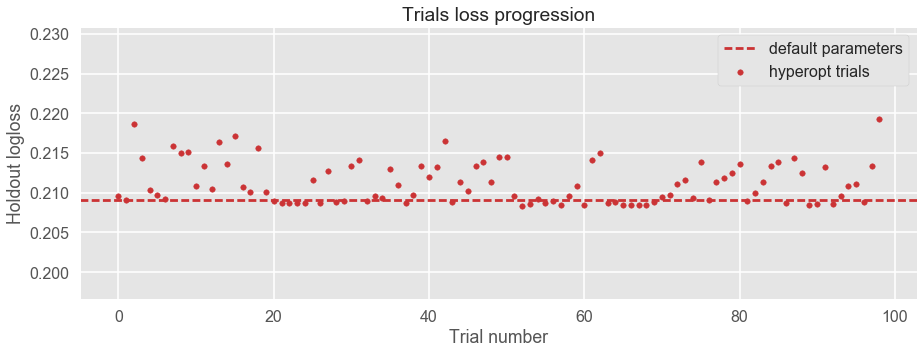

In [14]:
plt.figure(figsize=(15,5))
#xs = [t['misc']['vals']['bagging_fraction'] for t in trials.trials[:-1]]
xs = [t['misc']['tid'] for t in trials.trials[:-1]]
ys = [t['result']['loss'] for t in trials.trials[:-1]]

plt.scatter(xs, ys, s=30, label='hyperopt trials')
plt.axhline(y=initial_params_score, linestyle='--', label='default parameters')
plt.legend(frameon=True, framealpha=1)
plt.title('Trials loss progression')
plt.xlabel('Trial number')
plt.ylabel('Holdout logloss')
plt.show()

In [15]:
with open(os.path.join('data', 'lgb_best_params.pkl'), 'wb') as F:
    pickle.dump(best_params, F)